# Using sleuth for Differential analysis

Using mm9 genome so that the results can be more directly comparable to tables produced by elphege. We can see similarities and differences in the methods used for producing data relevant to DE analysis. 

In [10]:
library("sleuth")

In [11]:
suppressMessages({
  library("sleuth")
})

In [12]:
elphege_proj_files = "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652"
sample_id <- dir(file.path(elphege_proj_files,"SRP106652"))
kal_dirs <- file.path(elphege_proj_files, "SRP106652", sample_id, "kallisto-mm9")

In [13]:
kal_dirs

[1] "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517500/kallisto-mm9"
 [2] "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517501/kallisto-mm9"
 [3] "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517502/kallisto-mm9"
 [4] "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517503/kallisto-mm9"
 [5] "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517504/kallisto-mm9"
 [6] "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517505/kallisto-mm9"
 [7] "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517506/kallisto-mm9"
 [8] "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517507/kallisto-mm9"
 [9] "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517508/kallisto-mm9"
[10] "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517509/kallisto-mm9"
[11] "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517510/kallisto-mm9"
[12] "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517511/kallisto-mm9"
[13] "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517512/kallisto-mm9"
[14] "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517513/kallisto-mm9"
[15] "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517514/kallisto-mm9"
[16] "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517515/kallisto-mm9"
[17] "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517516/kallisto-mm9"
[18] "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517517/kallisto-mm9"
[19] "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517518/kallisto-mm9"
[20] "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517519/kallisto-mm9"
[21] "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517520/kallisto-mm9"
[22] "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517521/kallisto-mm9"
[23] "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517522/kallisto-mm9"
[24] "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517523/kallisto-mm9"

In [14]:
# Getting "Run" and "condition" from Experiment Name of the SRA deposits

sum <- read.table(file.path(elphege_proj_files, "metadata", "sra_result_summary.csv"), header = TRUE, sep = ",", stringsAsFactors=FALSE)

# Parse experiment name to get 'condition' -- str_split_fixed(string, pattern, n)
sum_extended <- cbind(sum,  stringr::str_split_fixed(sum$Experiment.Title, "[:;]+", 4))
colnames(sum_extended)[19] <- "condition"

# Removing replicate number so that sleuth can do some grouping
sum_extended$condition <- sub("_rep[0-4]", "", sum_extended$condition)

runInfo <- read.table(file.path(elphege_proj_files, "metadata", "SraRunInfo.csv"), header = TRUE, sep = ",", stringsAsFactors=FALSE)
head(runInfo, 5)

,Run,ReleaseDate,LoadDate,spots,bases,spots_with_mates,avgLength,size_MB,AssemblyName,download_path,⋯,Affection_Status,Analyte_Type,Histological_Type,Body_Site,CenterName,Submission,dbgap_study_accession,Consent,RunHash,ReadHash
,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<lgl>,<chr>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>
1,SRR5517500,2017-05-26 10:16:21,2017-05-08 17:35:25,28656716,4355820832,28656716,152,1603,NA,https://sra-downloadb.st-va.ncbi.nlm.nih.gov/sos1/sra-pub-run-8/SRR5517500/SRR5517500.1,⋯,NA,NA,NA,NA,GEO,SRA560605,NA,public,F81677DDDD471559B2F07AE966817AAF,7C8A3510A0405D532E497E49E19F67B9
2,SRR5517501,2017-05-26 10:16:21,2017-05-08 17:35:57,30176838,4586879376,30176838,152,1672,NA,https://sra-downloadb.st-va.ncbi.nlm.nih.gov/sos1/sra-pub-run-8/SRR5517501/SRR5517501.1,⋯,NA,NA,NA,NA,GEO,SRA560605,NA,public,B8469693637BD9B86CA631EDC8C3F149,850B6F66A9C3670E4D7A9D42ECEA8FDE
3,SRR5517502,2017-05-26 10:16:21,2017-05-08 17:55:26,41274152,6273671104,41274152,152,2310,NA,https://sra-downloadb.st-va.ncbi.nlm.nih.gov/sos1/sra-pub-run-8/SRR5517502/SRR5517502.1,⋯,NA,NA,NA,NA,GEO,SRA560605,NA,public,1EAA03FB52CABD86B77EDC88F938701C,AE5EA653D9F5031ABE66E27ABAEC2773
4,SRR5517503,2017-05-26 10:16:21,2017-05-08 17:39:08,28848858,4385026416,28848858,152,1603,NA,https://sra-downloadb.st-va.ncbi.nlm.nih.gov/sos1/sra-pub-run-8/SRR5517503/SRR5517503.1,⋯,NA,NA,NA,NA,GEO,SRA560605,NA,public,EC245424F964BB5621856DA6FCFB0ED2,264A772C22561DD1B389FC115F2767ED
5,SRR5517504,2017-05-26 10:16:21,2017-05-08 17:36:17,28605084,4347972768,28605084,152,1589,NA,https://sra-downloadb.st-va.ncbi.nlm.nih.gov/sos1/sra-pub-run-8/SRR5517504/SRR5517504.1,⋯,NA,NA,NA,NA,GEO,SRA560605,NA,public,238EDD94BDDEDACD0D2D51FAF7FE86AD,E9D992BB7AA74585B2AE37AF7953ED12


In [15]:
# merge sra_result file and sraRunInfo to get the condition (buried in 'Experiment Name' in sra_result_summary -- put in 'condition')

# runInfo.Experiment
# sum_extended.Experiment.Accession

total <- merge(runInfo, sum_extended, by.x=c("Experiment"),
      by.y=c("Experiment.Accession"),
      all.x=TRUE)

library(dplyr)

s2c <- select(total, Experiment, Run, condition, Library.Strategy, Library.Selection)
s2c <- dplyr::select(s2c, sample = Run, condition)

# getting rid of whitespace 
s2c %>%
  mutate(across(where(is.character), stringr::str_trim))


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




sample,condition
<chr>,<chr>
SRR5517500,RNA-seq_CTCF-AID_untreated
SRR5517501,RNA-seq_CTCF-AID_auxin1day
SRR5517502,RNA-seq_CTCF-AID_auxin2days
SRR5517503,RNA-seq_CTCF-AID_auxin4days
SRR5517504,RNA-seq_CTCF-AID_washoff2days
SRR5517505,RNA-seq_CTCF-AID_untreated
SRR5517506,RNA-seq_CTCF-AID_auxin1day
SRR5517507,RNA-seq_CTCF-AID_auxin2days
SRR5517508,RNA-seq_CTCF-AID_auxin4days


In [16]:
dplyr::select

function (.data, ...) 
{
    UseMethod("select")
}
<bytecode: 0x55a62b2c0548>
<environment: namespace:dplyr>

In [17]:
# Reformatting condition so that when converted to levels, we can put the base case first
## note: default behavior for sleuth will 

s2c$condition = as.factor(s2c$condition)

levels(s2c$condition)

# Getting rid of whitespace didn't work? so just going to try to se the base level
s2c$condition <- relevel(s2c$condition, ref = " RNA-seq_CTCF-AID_untreated")
s2c

[1] " RNA-seq_CTCF-AID_auxin1day"     " RNA-seq_CTCF-AID_auxin2days"   
[3] " RNA-seq_CTCF-AID_auxin4days"    " RNA-seq_CTCF-AID_untreated"    
[5] " RNA-seq_CTCF-AID_washoff2days"  " RNA-seq_WT-untagged_auxin2days"
[7] " RNA-seq_WT-untagged_auxin4days" " RNA-seq_WT-untagged_untreated"

sample,condition
<chr>,<fct>
SRR5517500,RNA-seq_CTCF-AID_untreated
SRR5517501,RNA-seq_CTCF-AID_auxin1day
SRR5517502,RNA-seq_CTCF-AID_auxin2days
SRR5517503,RNA-seq_CTCF-AID_auxin4days
SRR5517504,RNA-seq_CTCF-AID_washoff2days
SRR5517505,RNA-seq_CTCF-AID_untreated
SRR5517506,RNA-seq_CTCF-AID_auxin1day
SRR5517507,RNA-seq_CTCF-AID_auxin2days
SRR5517508,RNA-seq_CTCF-AID_auxin4days


In [19]:
s2c <- dplyr::mutate(s2c, path = kal_dirs)

s2c

sample,condition,path
<chr>,<fct>,<chr>
SRR5517500,RNA-seq_CTCF-AID_untreated,/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517500/kallisto-mm9
SRR5517501,RNA-seq_CTCF-AID_auxin1day,/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517501/kallisto-mm9
SRR5517502,RNA-seq_CTCF-AID_auxin2days,/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517502/kallisto-mm9
SRR5517503,RNA-seq_CTCF-AID_auxin4days,/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517503/kallisto-mm9
SRR5517504,RNA-seq_CTCF-AID_washoff2days,/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517504/kallisto-mm9
SRR5517505,RNA-seq_CTCF-AID_untreated,/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517505/kallisto-mm9
SRR5517506,RNA-seq_CTCF-AID_auxin1day,/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517506/kallisto-mm9
SRR5517507,RNA-seq_CTCF-AID_auxin2days,/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517507/kallisto-mm9
SRR5517508,RNA-seq_CTCF-AID_auxin4days,/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/SRP106652/SRR5517508/kallisto-mm9


# Adding gene aggregation

### Preparing target 2 gene mapping

t2g build using bioconductor, as seen in sleuth manual and tutorials. For reference:

```
library(biomaRt)

#for mm9 -- use ensembl version 54 / mmusculus genome NCBI37

mm9mart = useEnsembl(biomart="ensembl", version=54, dataset="mmusculus_gene_ensembl")

bioMartTargets <- getBM(attributes = c("ensembl_transcript_id", "ensembl_gene_id", "mgi_id"), mart = mm9mart)

```

In [10]:
bioMartTargets <- read.csv("/project/fudenber_735/genomes/mm9/ensembl/ensembl_relational_downloads/biomaRt_mm9_t2g.csv")

In [11]:
t2g = bioMartTargets[c("ensembl_transcript_id", "ensembl_gene_id", "mgi_symbol")]

In [12]:
head(t2g, 5)
dim(t2g)

,ensembl_transcript_id,ensembl_gene_id,mgi_symbol
,<fct>,<fct>,<fct>
1,ENSMUST00000115962,ENSMUSG00000079832,
2,ENSMUST00000099422,ENSMUSG00000074844,
3,ENSMUST00000115951,ENSMUSG00000079818,
4,ENSMUST00000115940,ENSMUSG00000079806,
5,ENSMUST00000096847,ENSMUSG00000079797,


[1] 50179     3

In [13]:
dim(t2g[which(t2g$mgi_symbol != ""),])

[1] 38921     3

Will try first without removing blank mgi --> not sure what type these are so it's possible that the aggregated genes we do get won't even be affected / might be good to know if we end up with a bunch of genes whose mgi symbol don't show up in this database. Then, might have to try a different mart/different download

In [14]:
t2g <- dplyr::rename(t2g, target_id = ensembl_transcript_id,
  ens_gene = ensembl_gene_id, ext_gene = mgi_symbol) 

In [15]:
t2g[which(t2g$target_id == "ENSMUST00000103741"),]

,target_id,ens_gene,ext_gene
,<fct>,<fct>,<fct>
49,ENSMUST00000103741,ENSMUSG00000076929,Igl-V1
50,ENSMUST00000103741,ENSMUSG00000076929,Igl-C1


In [16]:
head(t2g[duplicated(t2g$target_id),], 10)

,target_id,ens_gene,ext_gene
,<fct>,<fct>,<fct>
50,ENSMUST00000103741,ENSMUSG00000076929,Igl-C1
59,ENSMUST00000103749,ENSMUSG00000076937,Igl-C2
683,ENSMUST00000103574,ENSMUSG00000076765,EG667457
684,ENSMUST00000103574,ENSMUSG00000076765,EG673730
695,ENSMUST00000103583,ENSMUSG00000076773,Tcra-V22.4
700,ENSMUST00000103587,ENSMUSG00000076777,100043218
708,ENSMUST00000103593,ENSMUSG00000076783,EG667677
713,ENSMUST00000103597,ENSMUSG00000076787,EG667553
732,ENSMUST00000110632,ENSMUSG00000079098,100043218


In [17]:
# remove duplicated elements
t2g <- t2g[!duplicated(t2g$target_id),]

# check that one of the duplicates is still in there
t2g[which(t2g$target_id == "ENSMUST00000103741"),]

,target_id,ens_gene,ext_gene
,<fct>,<fct>,<fct>
49,ENSMUST00000103741,ENSMUSG00000076929,Igl-V1


In [18]:
# making sure that duplicate entries are now gone

#head(t2g[duplicated(t2g$target_id),], 10)
any(duplicated(t2g$target_id))

[1] FALSE

In [19]:
length(unique(t2g$target_id))

[1] 49039

In [20]:
head(t2g, 10)

,target_id,ens_gene,ext_gene
,<fct>,<fct>,<fct>
1,ENSMUST00000115962,ENSMUSG00000079832,
2,ENSMUST00000099422,ENSMUSG00000074844,
3,ENSMUST00000115951,ENSMUSG00000079818,
4,ENSMUST00000115940,ENSMUSG00000079806,
5,ENSMUST00000096847,ENSMUSG00000079797,
6,ENSMUST00000115916,ENSMUSG00000079777,
7,ENSMUST00000115902,ENSMUSG00000079764,
8,ENSMUST00000115901,ENSMUSG00000079763,
9,ENSMUST00000115890,ENSMUSG00000079756,


# Proceeding with sleuth model fitting

performing a quick LRT and then WT for each of the conditions

# Gene-level analysis: model transcripts, then aggregate pvals

In [21]:
so_gene <- sleuth_prep(s2c, target_mapping = t2g, aggregation_column = 'ens_gene', extra_bootstrap_summary = TRUE, num_cores=1)

reading in kallisto results

dropping unused factor levels

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


normalizing est_counts

48055 targets passed the filter

normalizing tpm

merging in metadata

summarizing bootstraps

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.




In [22]:
so_gene <- sleuth_fit(so_gene, ~condition, 'full')

fitting measurement error models

shrinkage estimation

1 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: ENSMUST00000049324

computing variance of betas



In [23]:
so_gene <- sleuth_fit(so_gene, ~1, 'reduced')

fitting measurement error models

shrinkage estimation

computing variance of betas



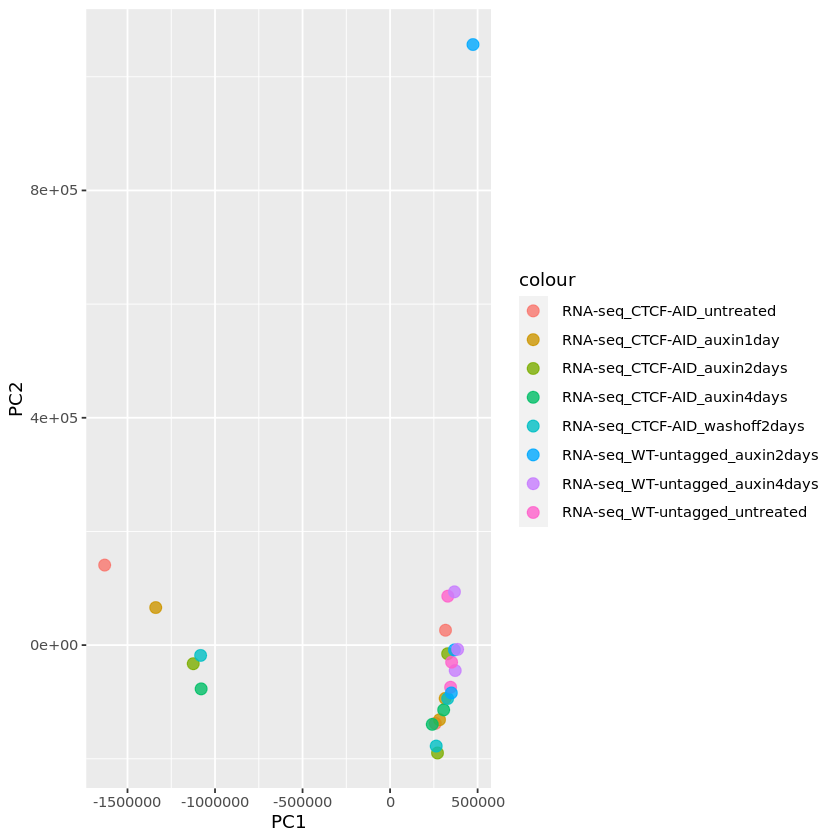

In [33]:
plot_pca(so_gene, color_by = s2c$condition, width=500, height=100)

In [20]:
plot_group_density(so_gene, use_filtered = TRUE, units = "est_counts",trans = "log", grouping = s2c$condition, offset = 1) 

ERROR: Error in is(obj, "sleuth"): object 'so_gene' not found


In [39]:
ppv <- plot_pc_variance(so_gene)
PCpc <- ppv$data$var
names(PCpc) <- paste0("PC", seq(1:length(PCpc)))

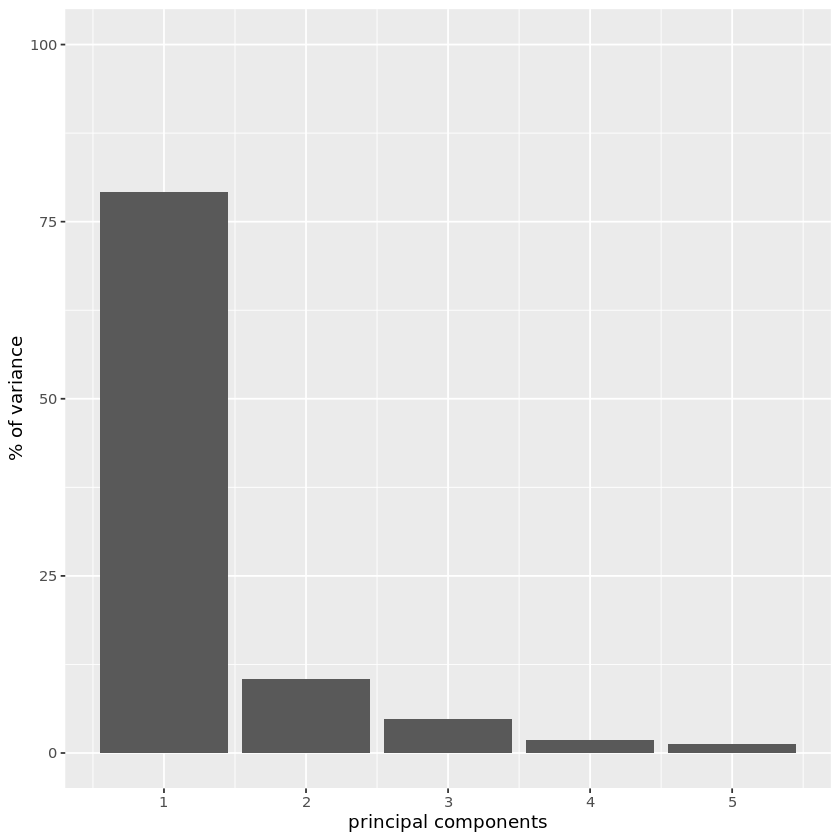

In [40]:
show(ppv)

## Comparison: TPM from sleuth to FPKM from elphege

--> exported and moved to python for ~ ease ~. See notebook: `compare-sleuth-results.ipynb` instead

In [24]:
sleuth_matrix <- sleuth_to_matrix(so_gene, 'obs_norm', 'tpm')

Warning message:
"`select_()` was deprecated in dplyr 0.7.0.
Please use `select()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated."


In [25]:
# sleuth_matrix

In [26]:
# cols = s2c[which(levels(s2c$condition)[1] == s2c$condition), ]$sample

# #select.me <- c(cols[1], cols[2], cols[3])

# #sleuth_matrix[ , select.me]

# # head(sleuth_matrix[ , names(sleuth_matrix %in% select.me)], 4)

# dplyr::select(sleuth_matrix, c(cols[1], cols[2], cols[3]))

# # sleuth_matrix <- sleuth_matrix %>% 
# #   mutate(avgTPM = mean(c_across(cols[1], cols[2], cols[3]))) %>%
# #   head()

In [27]:
# gene_and_symbol<-as.data.frame(cbind(t2g$ens_gene,t2g$ext_gene))
# colnames(gene_and_symbol)<-c("target_id","ext_gene")
# gene_and_symbol<-dplyr::distinct(gene_and_symbol,target_id,.keep_all=TRUE)

# sleuth_matrix_genes_level<-left_join(sleuth_matrix,gene_and_symbol)

In [60]:
write.csv(sleuth_matrix, "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/supplementary/sleuth_matrix.csv")

In [61]:
write.csv(s2c, "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/supplementary/s2c.csv")

## Gene-level analysis: p-value Aggregation method

The recommended aggregation method is to do use pval aggregation. However, this method does not return all the columns needed to asses DEGs (specifically, beta for wald test)
https://www.rdocumentation.org/packages/sleuth/versions/0.30.0/topics/sleuth_results

In [41]:
so_gene <- sleuth_lrt(so_gene, 'reduced', 'full')
lrt_results <- sleuth_results(so_gene, 'reduced:full', 'lrt', pval_aggregate=TRUE, show_all = TRUE)

In [42]:
head(lrt_results, 5)
dim(lrt_results)

,target_id,ext_gene,num_aggregated_transcripts,sum_mean_obs_counts,pval,qval
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,ENSMUSG00000028013,Ppa2,3,12.841514,3.936264e-19,6.522784e-15
2,ENSMUSG00000043073,EG625530,2,11.312923,9.259837e-17,7.672238e-13
3,ENSMUSG00000023036,Pcdhga11,9,40.535291,3.548994e-16,1.960346e-12
4,ENSMUSG00000048583,Igf2,5,24.022722,7.798495e-14,3.230721e-10
5,ENSMUSG00000020392,Cdkn2aipnl,1,7.556659,1.079232e-13,3.576791e-10


[1] 31804     6

In [43]:
lrt_results_no_agg <- sleuth_results(so_gene, 'reduced:full', 'lrt', pval_aggregate=FALSE, show_all = TRUE)
head(lrt_results_no_agg, 10)
dim(lrt_results_no_agg)

,target_id,ens_gene,ext_gene,pval,qval,test_stat,rss,degrees_free,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSMUST00000029644,ENSMUSG00000028013,Ppa2,3.047563e-14,1.464506e-09,78.30769,22.20803,7,6.862515,0.9655665,0.0029059542,0.9626605,0.09593575,0.9626605
2,ENSMUST00000102763,ENSMUSG00000020392,Cdkn2aipnl,1.079232e-13,2.593125e-09,75.60788,16.36757,7,7.556659,0.7116337,0.0008762691,0.7107574,0.07613686,0.7107574
3,ENSMUST00000078953,ENSMUSG00000015377,Fam116b,4.004208e-13,4.026421e-09,72.80175,44.93722,7,5.188072,1.9537923,0.0177739637,1.9360183,0.21619344,1.9360183
4,ENSMUST00000006451,ENSMUSG00000006288,Ttc5,3.690048e-13,4.026421e-09,72.97684,20.41545,7,7.017841,0.8876284,0.0033801130,0.8842483,0.09048501,0.8842483
5,ENSMUST00000155572,NA,NA,4.189388e-13,4.026421e-09,72.70486,16.65296,7,8.060573,0.7240418,0.0004519891,0.7235898,0.06742466,0.7235898
6,ENSMUST00000168900,NA,NA,6.272445e-13,5.023706e-09,71.83944,20.21256,7,7.059538,0.8788068,0.0019773653,0.8768295,0.08914646,0.8768295
7,ENSMUST00000171066,NA,NA,1.212480e-12,8.255836e-09,70.42464,24.01509,7,9.518412,1.0441342,0.0001302209,1.0440040,0.06076378,1.0440040
8,ENSMUST00000136299,NA,NA,1.374398e-12,8.255836e-09,70.15534,26.36358,7,8.066746,1.1462428,0.0004998462,1.1457429,0.06734164,1.1457429
9,ENSMUST00000014892,ENSMUSG00000014748,Tex261,2.382672e-12,1.272214e-08,68.97237,15.94276,7,6.670008,0.6931633,0.0027184562,0.6904448,0.10375566,0.6904448


[1] 88366    14

In [44]:
# We lose most of the useful information about expression levels when doing aggregation. 

# how many ens_gene names have at least one transcript
length(unique(lrt_results_no_agg[duplicated(lrt_results_no_agg$ens_gene),]$ens_gene))

[1] 7874

In [45]:
# do all of the aggregated transcripts show up separately when no aggreggation?
# looking at 'ENSMUSG00000023036', that had 9 aggregated transcripts:
lrt_results_no_agg[which(lrt_results_no_agg$ens_gene=='ENSMUSG00000023036'),]

,target_id,ens_gene,ext_gene,pval,qval,test_stat,rss,degrees_free,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
147,ENSMUST00000073447,ENSMUSG00000023036,Pcdhga11,3.024118e-07,9.885986e-05,43.220443,52.452372,7,4.163996,2.2805379,0.167036960,2.11350095,0.3820925,2.1135010
164,ENSMUST00000091935,ENSMUSG00000023036,Pcdhga11,6.761956e-07,1.981377e-04,41.407058,85.749415,7,3.325960,3.7282354,0.301477158,3.42675826,0.6158432,3.4267583
295,ENSMUST00000066149,ENSMUSG00000023036,Pcdhga11,6.841357e-06,1.114445e-03,36.133264,59.316069,7,4.210621,2.5789595,0.200318222,2.37864131,0.3721965,2.3786413
319,ENSMUST00000061279,ENSMUSG00000023036,Pcdhga11,1.057301e-05,1.592746e-03,35.129879,15.241537,7,5.356267,0.6626755,0.082653909,0.58002160,0.1972190,0.5800216
1470,ENSMUST00000044851,ENSMUSG00000023036,Pcdhga11,3.932808e-03,1.285654e-01,20.892336,4.668241,7,5.792533,0.2029670,0.010056279,0.19291073,0.1567535,0.1929107
23771,ENSMUST00000091934,ENSMUSG00000023036,Pcdhga11,8.009913e-01,1.000000e+00,3.813494,6.331399,7,3.168518,0.2752782,0.146009503,0.12926872,0.6660438,0.6660438
23772,ENSMUST00000055935,ENSMUSG00000023036,Pcdhga11,7.424708e-01,1.000000e+00,4.318310,4.694338,7,4.045651,0.2041017,0.300873034,-0.09677138,0.4081367,0.4081367
23773,ENSMUST00000066140,ENSMUSG00000023036,Pcdhga11,6.849932e-01,1.000000e+00,4.794759,5.510157,7,3.769013,0.2395720,0.123501300,0.11607074,0.4748645,0.4748645
23774,ENSMUST00000076807,ENSMUSG00000023036,Pcdhga11,4.691107e-01,1.000000e+00,6.623437,4.910299,7,6.702732,0.2134912,0.004727993,0.20876325,0.1023400,0.2087632


# Looking at some Set differences between significant DE genes and the conditions:

In [46]:
sleuth_significant_lrt <- dplyr::filter(lrt_results, qval <= 0.05)

print("total Number of Genes in LRT model with p-val aggregation: ")
length(unique(lrt_results$target_id))
print("Total number of significant DE in LRT model with p-val aggregation: ")
print(count(sleuth_significant_lrt))

sig_genes_LRT = unique(sleuth_significant_lrt$target_id)
nonsig_genes_LRT = setdiff(unique(lrt_results$target_id), unique(sleuth_significant_lrt$target_id))

print("Number of nonsig genes (qval > 0.05): ")
print(length(nonsig_genes_LRT))

[1] "total Number of Genes in LRT model with p-val aggregation: "


[1] 31804

[1] "Total number of significant DE in LRT model with p-val aggregation: "
    n
1 953
[1] "Number of nonsig genes (qval > 0.05): "
[1] 30851


In [47]:
head(sig_genes_LRT, 3)

[1] "ENSMUSG00000028013" "ENSMUSG00000043073" "ENSMUSG00000023036"

In [48]:
head(nonsig_genes_LRT, 3)

[1] "ENSMUSG00000029407" "ENSMUSG00000022099" "ENSMUSG00000037390"

In [49]:
head(lrt_results, 5)
dim(lrt_results)
dim(sleuth_significant_lrt)

,target_id,ext_gene,num_aggregated_transcripts,sum_mean_obs_counts,pval,qval
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,ENSMUSG00000028013,Ppa2,3,12.841514,3.936264e-19,6.522784e-15
2,ENSMUSG00000043073,EG625530,2,11.312923,9.259837e-17,7.672238e-13
3,ENSMUSG00000023036,Pcdhga11,9,40.535291,3.548994e-16,1.960346e-12
4,ENSMUSG00000048583,Igf2,5,24.022722,7.798495e-14,3.230721e-10
5,ENSMUSG00000020392,Cdkn2aipnl,1,7.556659,1.079232e-13,3.576791e-10


[1] 31804     6

[1] 953   6

Percentage of significant genes from the aggregated transcripts using LRT:

In [50]:
953/16571

[1] 0.05751011

In [51]:
# checking target mapping for missing values because of issues in gene mode (below):
count(t2g[t2g$ens_gene=="",])

n
<int>
0


## Wald test for all

--> using so_gene, and no pval aggregation. 
--> The something seems to be wrong with so_genemode during set-up, so will instead not do aggregation now, but 

In [61]:
# Performing wald test for first beta condition (at index=2 of s2c)
condition = s2c$condition[2]

print(paste("Looking at condition", condition))
so_gene <- sleuth_wt(so_gene, which_beta = paste("condition",condition, sep=""))
wald_res <- sleuth_results(so_gene, test = paste("condition",condition, sep=""), test_type = 'wt', pval_aggregate=FALSE, show_all = TRUE)

[1] "Looking at condition  RNA-seq_CTCF-AID_auxin1day"


In [62]:
head(wald_res, 5)

,target_id,ens_gene,ext_gene,pval,qval,b,se_b,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSMUST00000168900,NA,NA,2.872365e-17,1.380315e-12,-1.905176,0.2254208,7.059538,0.8788068,0.0019773653,0.04489230,0.07424445,0.07424445
2,ENSMUST00000102763,ENSMUSG00000020392,Cdkn2aipnl,6.894337e-16,1.606176e-11,-1.662413,0.2059385,7.556659,0.7116337,0.0008762691,0.02037499,0.06273970,0.06273970
3,ENSMUST00000006451,ENSMUSG00000006288,Ttc5,1.002711e-15,1.606176e-11,-1.839779,0.2292124,7.017841,0.8876284,0.0033801130,0.03671444,0.07542735,0.07542735
4,ENSMUST00000029644,ENSMUSG00000028013,Ppa2,1.007347e-14,1.210202e-10,-1.821647,0.2354059,6.862515,0.9655665,0.0029059542,0.01553460,0.08021792,0.08021792
5,ENSMUST00000108830,ENSMUSG00000001482,Def8,1.827492e-13,1.756403e-09,-6.382005,0.8670207,3.389990,8.9131355,0.2951307665,0.83245665,0.57447928,0.83245665


In [63]:
# Look at how many transcripts there are for a significantly expressed gene (for pval_aggregate=FALSE mode): 

# wald_res[which(wald_res$ens_gene == 'ENSMUSG00000028013'),]

In [64]:
# looks like only one of the transcripts has a significant qval, and it's data generally/approximately aligns with the data from the aggregation

In [65]:
sleuth_significant_wt <- dplyr::filter(wald_res, qval <= 0.05)

print(paste("total Number of Genes in WT model with p-val aggregation, for condition: ", condition))
length(unique(wald_res$target_id))
print("Total number of significant DE in WT model with p-val aggregation: ")
print(length(unique(sleuth_significant_wt$target_id)))

sig_genes_WT = unique(sleuth_significant_wt$target_id)
nonsig_genes_WT = setdiff(unique(wald_res$target_id), unique(sleuth_significant_wt$target_id))


print("Number of nonsig genes (qval > 0.05): ")
print(length(nonsig_genes_WT))

[1] "total Number of Genes in WT model with p-val aggregation, for condition:   RNA-seq_CTCF-AID_auxin1day"


[1] 88366

[1] "Total number of significant DE in WT model with p-val aggregation: "
[1] 76
[1] "Number of nonsig genes (qval > 0.05): "
[1] 88290


In [66]:
sleuth_significant_wt <- dplyr::filter(wald_res, qval <= 0.05)

print(paste("total Number of Genes in WT model without p-val aggregation, for condition: ", condition))
length(unique(wald_res$ens_gene))
print("Total number of significant DE in WT model with p-val aggregation: ")
print(length(unique(sleuth_significant_wt$ens_gene)))

sig_genes_WT = unique(sleuth_significant_wt$ens_gene)
nonsig_genes_WT = setdiff(unique(wald_res$ens_gene), unique(sleuth_significant_wt$ens_gene))


print("Number of nonsig genes (qval > 0.05): ")
print(length(nonsig_genes_WT))

[1] "total Number of Genes in WT model without p-val aggregation, for condition:   RNA-seq_CTCF-AID_auxin1day"


[1] 26521

[1] "Total number of significant DE in WT model with p-val aggregation: "
[1] 63
[1] "Number of nonsig genes (qval > 0.05): "
[1] 26458


In [67]:
# Looking at intersections

print(length(intersect(sig_genes_WT, nonsig_genes_WT)))
print(length(intersect(sig_genes_LRT, sig_genes_WT)))
print(length(intersect(nonsig_genes_LRT, nonsig_genes_WT)))

print(length(intersect(nonsig_genes_LRT, sig_genes_WT)))
print(length(intersect(sig_genes_LRT, nonsig_genes_WT)))

[1] 0
[1] 61
[1] 25566
[1] 1
[1] 892


In [68]:
count(dplyr::filter(wald_res, qval <= 0.05))

n
<int>
76


In [70]:
head(sleuth_results(so_gene, "condition RNA-seq_CTCF-AID_auxin1day"), 4)

,target_id,ext_gene,num_aggregated_transcripts,sum_mean_obs_counts,pval,qval
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,ENSMUSG00000028013,Ppa2,3,12.841514,1.065986e-15,5.888149e-12
2,ENSMUSG00000020392,Cdkn2aipnl,1,7.556659,6.894337e-16,5.888149e-12
3,ENSMUSG00000006288,Ttc5,1,7.017841,1.002711e-15,5.888149e-12
4,ENSMUSG00000030532,Hddc3,1,4.413944,1.137684e-12,3.770512e-09


ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'mean_obs' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste

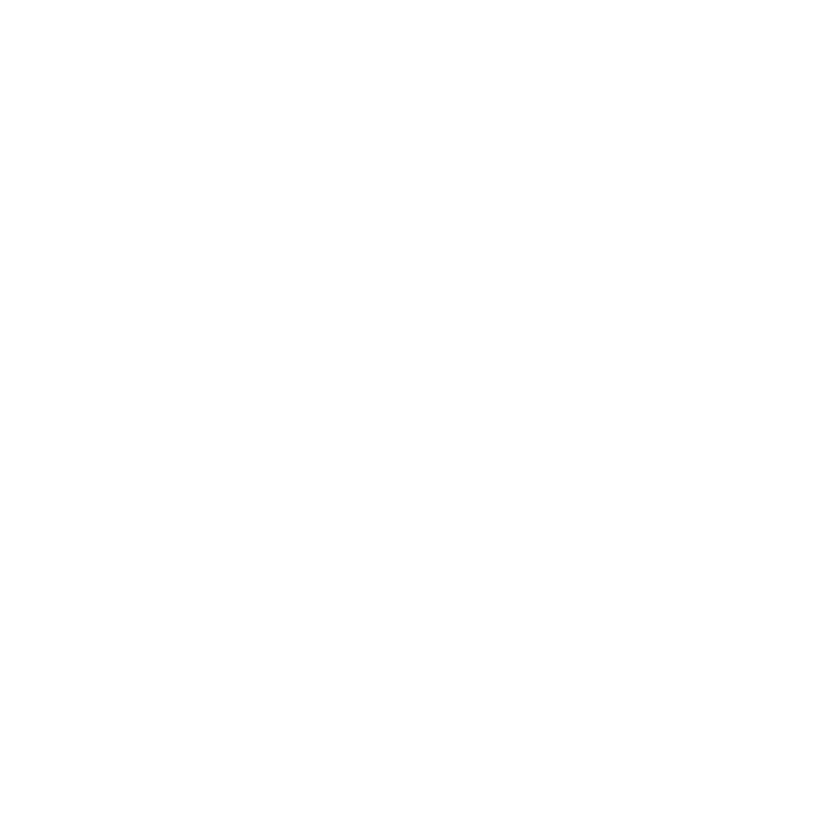

In [71]:
plot_ma(so_gene, "condition RNA-seq_CTCF-AID_auxin1day")

In [120]:
mergecols <- results %>%
        select(target_id, sum_mean_obs_counts, pval, qval, b, se_b)

print(paste("Total number of significant differentially expressed genes: ",count(dplyr::filter(results, qval <= 0.05)), sep=""))

ERROR: [1m[33mError[39m in [1m[1m[30m[47m`stop_subscript()`[49m[39m:[22m
[33m![39m Can't subset columns that don't exist.
[31mx[39m Column `b` doesn't exist.


# Gene-level analysis: gene mode

from docs:
"In this mode, the modeling and testing was done using aggregated counts (or TPMs), and so the results are same as for the transcript-level results, except the target IDs are now gene IDs instead of transcript IDs."

Note: Getting lot's of warnings in the prep using this method.

## Pachter lab updates / recommendations for gene aggregation

Pausing here, https://github.com/pachterlab/sleuth/issues/164

https://www.biorxiv.org/content/10.1101/190199v1.full.pdf

In [226]:
so_genemode <- sleuth_prep(s2c, target_mapping = t2g, aggregation_column = 'ens_gene', gene_mode=TRUE, num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.

reading in kallisto results

dropping unused factor levels

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


normalizing est_counts

48055 targets passed the filter

normalizing tpm

merging in metadata

aggregating by column: ens_gene

16571 genes passed the filter

Warning message in sleuth_prep(s2c, target_mapping = t2g, aggregation_column = "ens_gene", :
"47421 target_ids are missing annotations for the aggregation_column: ens_gene.
These target_ids will be dropped from the gene-level analysis.
If you did not expect this, check your 'target_mapping' table for missing values."
summarizing bootstraps

.
Warning message in data.table::melt(bs_df, id.vars = "bootstrap_num", variable.name = "target_id", :
"The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant re

In [171]:
so_genemode <- sleuth_fit(so_genemode, ~condition, 'full')

fitting measurement error models

shrinkage estimation

2 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: ENSMUSG00000018634, ENSMUSG00000052372

computing variance of betas



In [172]:
so_genemode <- sleuth_fit(so_genemode, ~1, 'reduced')

fitting measurement error models

shrinkage estimation

2 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: ENSMUSG00000018634, ENSMUSG00000052372

computing variance of betas



In [175]:
so_genemode <- sleuth_lrt(so_genemode, 'reduced', 'full')
lrt_results_genemode <- sleuth_results(so_genemode, 'reduced:full', 'lrt', show_all = TRUE)

In [189]:
head(lrt_results_genemode, 5)
dim(lrt_results_genemode)
sleuth_significant_lrt_genemode <- dplyr::filter(lrt_results_genemode, qval <= 0.05)
dim(sleuth_significant_lrt_genemode)

,target_id,ext_gene,pval,qval,test_stat,rss,degrees_free,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSMUSG00000028013,Ppa2,1.088193e-15,1.803245e-11,85.39500,22.76519,7,6.940018,0.9897908,0.0023897340,0.9874011,0.06767982,0.9874011
2,ENSMUSG00000015377,Fam116b,2.792723e-15,2.313910e-11,83.39430,44.93722,7,5.188072,1.9537923,0.0177739637,1.9360183,0.14329708,1.9360183
3,ENSMUSG00000020392,Cdkn2aipnl,1.363844e-14,7.533422e-11,80.02122,16.36757,7,7.556659,0.7116337,0.0008762691,0.7107574,0.05894051,0.7107574
4,ENSMUSG00000006288,Ttc5,4.301347e-14,1.781940e-10,77.57258,20.41545,7,7.017841,0.8876284,0.0033801130,0.8842483,0.06625875,0.8842483
5,ENSMUSG00000014748,Tex261,6.555817e-14,2.172729e-10,76.67293,15.94276,7,6.670008,0.6931633,0.0027184562,0.6904448,0.07357323,0.6904448


[1] 31804    13

[1] 1847   13

In [190]:
1847/31804

[1] 0.05807446

In [26]:
sleuth_matrix_gene <- sleuth_to_matrix(so_genemode, 'obs_norm', 'tpm')
head(sleuth_matrix_gene, 5)

ERROR: Error in is(obj, "sleuth"): object 'so_genemode' not found


In [202]:
length(which(lrt_results_genemode$target_id == lrt_results$target_id))
length(which(lrt_results_genemode$target_id != lrt_results$target_id))

[1] 15237

[1] 16567

In [214]:
# checking wald test in genemode model
so_genemode <- sleuth_wt(so_genemode, which_beta = paste("condition",s2c$condition[2], sep=""))
wald_res_genemode <- sleuth_results(so_genemode, test = paste("condition",s2c$condition[2], sep=""), test_type = 'wt', show_all = TRUE)

In [215]:
head(wald_res_genemode , 5)

,target_id,ext_gene,pval,qval,b,se_b,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSMUSG00000028013,Ppa2,5.602543e-21,4.028510e-17,-1.835536,0.1953277,6.940018,0.9897908,0.0023897340,0.01912580,0.05483960,0.05483960
2,ENSMUSG00000030532,Hddc3,7.293182e-21,4.028510e-17,-3.597136,0.3839230,4.413944,2.6447887,0.0796148464,0.02296489,0.14148040,0.14148040
3,ENSMUSG00000006288,Ttc5,4.778830e-21,4.028510e-17,-1.839779,0.1954314,7.017841,0.8876284,0.0033801130,0.03671444,0.05391002,0.05391002
4,ENSMUSG00000020392,Cdkn2aipnl,6.917972e-20,2.396414e-16,-1.662413,0.1821038,7.556659,0.7116337,0.0008762691,0.02037499,0.04886641,0.04886641
5,ENSMUSG00000015377,Fam116b,7.230746e-20,2.396414e-16,-2.554509,0.2799725,5.188072,1.9537923,0.0177739637,0.03407843,0.09980294,0.09980294


## General steps:

* Use p_val aggregation to get general data: aggregated pval, sum_obs_counts, etc
* then, use transcript-level wald test to assess DE --> map only this value

In [119]:
colnames(mergecols)[1] = "hi"

head(mergecols, 4)

,hi,sum_mean_obs_counts,pval,qval
,<chr>,<dbl>,<dbl>,<dbl>
1,ENSMUSG00000028013,12.841514,1.065986e-15,5.888149e-12
2,ENSMUSG00000020392,7.556659,6.894337e-16,5.888149e-12
3,ENSMUSG00000006288,7.017841,1.002711e-15,5.888149e-12
4,ENSMUSG00000030532,4.413944,1.137684e-12,3.770512e-09


In [60]:
head(results, 10)
dim(results)

,target_id,ext_gene,num_aggregated_transcripts,sum_mean_obs_counts,pval,qval
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,ENSMUSG00000028013,Ppa2,3,12.841514,1.065986e-15,5.888149e-12
2,ENSMUSG00000020392,Cdkn2aipnl,1,7.556659,6.894337e-16,5.888149e-12
3,ENSMUSG00000006288,Ttc5,1,7.017841,1.002711e-15,5.888149e-12
4,ENSMUSG00000030532,Hddc3,1,4.413944,1.137684e-12,3.770512e-09
5,ENSMUSG00000023036,Pcdhga11,9,40.535291,1.086197e-12,3.770512e-09
6,ENSMUSG00000015377,Fam116b,1,5.188072,6.639283e-12,1.833659e-08
7,ENSMUSG00000027164,Traf6,1,5.892552,1.002905e-11,1.846571e-08
8,ENSMUSG00000031672,Got2,1,8.730232,9.885852e-12,1.846571e-08
9,ENSMUSG00000014748,Tex261,1,6.670008,8.574306e-12,1.846571e-08


[1] 31804     6

In [61]:
print(levels(s2c$condition))

[1] " RNA-seq_CTCF-AID_untreated"     " RNA-seq_CTCF-AID_auxin1day"    
[3] " RNA-seq_CTCF-AID_auxin2days"    " RNA-seq_CTCF-AID_auxin4days"   
[5] " RNA-seq_CTCF-AID_washoff2days"  " RNA-seq_WT-untagged_auxin2days"
[7] " RNA-seq_WT-untagged_auxin4days" " RNA-seq_WT-untagged_untreated" 


In [72]:
# adding the results of each test to one table
## failed attempt idk why it doesn't work for the gene version
for(cond in levels(s2c$condition)) {
    if (cond != levels(s2c$condition)[1]) {
        
        print(paste("General information for condition: ", cond, sep=""))
        
        so_gene <- sleuth_wt(so_gene, which_beta = paste("condition", cond, sep=""))
        res <- sleuth_results(so_gene, test = paste("condition", cond, sep=""), show_all = FALSE)
        print(paste("Total number of significant differentially expressed genes: ", count(dplyr::filter(res, qval <= 0.05)), sep=""))

        
        # Only keeping non-redundant columns, plus the target_id for identification
        mergecols <- res %>%
            select(target_id, sum_mean_obs_counts, pval, qval)
        
        # Adding condition to column name before merging
        colnames(res) <- paste(colnames(res),cond,sep="_")
        
        
        # first, initialize new wt if this is a new set
        if(cond == levels(s2c$condition)[2]) {
            colnames(res)[1] = "target_id" # removing condition description from target_id
            sleuth_results_wt <- res
            
        } else {
            sleuth_results_wt <- merge(sleuth_results_wt, res, 
                                       by.x = colnames(sleuth_results_wt)[1], 
                                       by.y = colnames(res)[1],
                                       all.x = TRUE,
                                       all.y = TRUE)        }
        
    }
}


[1] "General information for condition:  RNA-seq_CTCF-AID_auxin1day"
[1] "Total number of significant differentially expressed genes: 86"
[1] "General information for condition:  RNA-seq_CTCF-AID_auxin2days"
[1] "Total number of significant differentially expressed genes: 185"
[1] "General information for condition:  RNA-seq_CTCF-AID_auxin4days"
[1] "Total number of significant differentially expressed genes: 1279"
[1] "General information for condition:  RNA-seq_CTCF-AID_washoff2days"
[1] "Total number of significant differentially expressed genes: 24"
[1] "General information for condition:  RNA-seq_WT-untagged_auxin2days"
[1] "Total number of significant differentially expressed genes: 4"
[1] "General information for condition:  RNA-seq_WT-untagged_auxin4days"
[1] "Total number of significant differentially expressed genes: 5"
[1] "General information for condition:  RNA-seq_WT-untagged_untreated"
[1] "Total number of significant differentially expressed genes: 3"


In [73]:
head(sleuth_results_wt, 20)
dim(sleuth_results_wt)

,target_id,ext_gene_ RNA-seq_CTCF-AID_auxin1day,num_aggregated_transcripts_ RNA-seq_CTCF-AID_auxin1day,sum_mean_obs_counts_ RNA-seq_CTCF-AID_auxin1day,pval_ RNA-seq_CTCF-AID_auxin1day,qval_ RNA-seq_CTCF-AID_auxin1day,ext_gene_ RNA-seq_CTCF-AID_auxin2days,num_aggregated_transcripts_ RNA-seq_CTCF-AID_auxin2days,sum_mean_obs_counts_ RNA-seq_CTCF-AID_auxin2days,pval_ RNA-seq_CTCF-AID_auxin2days,⋯,ext_gene_ RNA-seq_WT-untagged_auxin4days,num_aggregated_transcripts_ RNA-seq_WT-untagged_auxin4days,sum_mean_obs_counts_ RNA-seq_WT-untagged_auxin4days,pval_ RNA-seq_WT-untagged_auxin4days,qval_ RNA-seq_WT-untagged_auxin4days,ext_gene_ RNA-seq_WT-untagged_untreated,num_aggregated_transcripts_ RNA-seq_WT-untagged_untreated,sum_mean_obs_counts_ RNA-seq_WT-untagged_untreated,pval_ RNA-seq_WT-untagged_untreated,qval_ RNA-seq_WT-untagged_untreated
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,⋯,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,ENSMUSG00000000001,Gnai3,1,8.655712,0.905705444,1.0000000,Gnai3,1,8.655712,0.7355967750,⋯,Gnai3,1,8.655712,0.17616517,0.9999882,Gnai3,1,8.655712,0.3342214,0.9999742
2,ENSMUSG00000000028,Cdc45l,2,13.832493,0.964720091,1.0000000,Cdc45l,2,13.832493,0.3929913011,⋯,Cdc45l,2,13.832493,0.64266493,0.9999882,Cdc45l,2,13.832493,0.6930097,0.9999742
3,ENSMUSG00000000037,Scml2,6,17.754630,0.008941752,0.7149052,Scml2,6,17.754630,0.0002887995,⋯,Scml2,6,17.754630,0.06472297,0.9999882,Scml2,6,17.754630,0.1189984,0.9999742
4,ENSMUSG00000000056,Narf,1,6.753225,0.841518758,1.0000000,Narf,1,6.753225,0.9562774905,⋯,Narf,1,6.753225,0.34977290,0.9999882,Narf,1,6.753225,0.3151654,0.9999742
5,ENSMUSG00000000058,Cav2,1,3.232592,0.315200646,1.0000000,Cav2,1,3.232592,0.0089185983,⋯,Cav2,1,3.232592,0.24903364,0.9999882,Cav2,1,3.232592,0.5007491,0.9999742
6,ENSMUSG00000000078,Klf6,1,7.715875,0.424791110,1.0000000,Klf6,1,7.715875,0.0222408949,⋯,Klf6,1,7.715875,0.62366469,0.9999882,Klf6,1,7.715875,0.8013308,0.9999742
7,ENSMUSG00000000085,Scmh1,2,11.008463,0.085290985,1.0000000,Scmh1,2,11.008463,0.4914930403,⋯,Scmh1,2,11.008463,0.80752862,0.9999882,Scmh1,2,11.008463,0.5138481,0.9999742
8,ENSMUSG00000000088,Cox5a,1,9.142045,0.914178821,1.0000000,Cox5a,1,9.142045,0.7726463677,⋯,Cox5a,1,9.142045,0.61384708,0.9999882,Cox5a,1,9.142045,0.5845718,0.9999742
9,ENSMUSG00000000093,Tbx2,1,2.970723,0.841847828,1.0000000,Tbx2,1,2.970723,0.4838007876,⋯,Tbx2,1,2.970723,0.82410740,0.9999882,Tbx2,1,2.970723,0.8893849,0.9999742


[1] 16571    36

In [74]:
# instead, printing/saving all the results to .csv
for(cond in levels(s2c$condition)) {
    print(cond)
    
    if (cond != levels(s2c$condition)[1]) {
        
        so_gene <- sleuth_wt(so_gene, which_beta = paste("condition",cond, sep=""))
        res <- sleuth_results(so_gene, test = paste("condition",cond, sep=""), test_type = 'wt', pval_aggregate=FALSE, show_all = TRUE)
        colnames(res) <- paste(colnames(res),cond,sep="_")
        
        write.csv(res,file.path(elphege_proj_files, "WT-mm9-results", paste("sleuth_WT_", cond, ".csv", sep="")))
    }
        
}

[1] " RNA-seq_CTCF-AID_untreated"
[1] " RNA-seq_CTCF-AID_auxin1day"
[1] " RNA-seq_CTCF-AID_auxin2days"
[1] " RNA-seq_CTCF-AID_auxin4days"
[1] " RNA-seq_CTCF-AID_washoff2days"
[1] " RNA-seq_WT-untagged_auxin2days"
[1] " RNA-seq_WT-untagged_auxin4days"
[1] " RNA-seq_WT-untagged_untreated"


# Comparison with Elphege's data

## First, looking at basic information:

* % of upregulated vs. down
   * "The absolute number of differentially expressed genes increased more than 10-fold between day 1 (370) and day 4 (4,996) (Figures S6A and S6B), and around half of the dysregulated genes were downregulated and half were upregulated at each time point." 
* Set differences between supplemental-table-10 and sleuth DE predictions
   * total number of genes
   * number up-regulated/down-regulated at each step in process
   

ERROR: Error in readxl("/scratch/pokorny/Elphege_2017/sup_data/NIHMS873912-supplement-10.xlsx", : could not find function "readxl"


## Try other approach: all log-fold differences calculated using LRT

"If you are doing a simple comparison between wild-type and mutant samples, then you can technically do the wald test. However, in our preprint [1], all of the analyses are done with the likelihood ratio test. This is because we found that the FDR is much more believable under the likelihood ratio test then the Wald test. My general impression is that the Wald test gives too many false positives, although, the rankings are fairly comparable between the two tests." - H. Pimental

https://www.biostars.org/p/226022/

In [32]:
# # Otherwise, saving the results of each test -- can aggregate together some other time <3
# for(cond in levels(s2c$condition)) {
#     if (cond != levels(s2c$condition)[1]) {
        
        

ERROR: Error in parse(text = x, srcfile = src): <text>:6:0: unexpected end of input
4:         
5:         
  ^


# Deprecated / Not pursued

but keeping in case a code reference is needed / so I may learn from my mistakes

In [23]:
# sleuth_matrix

In [56]:
# cols = s2c[which(levels(s2c$condition)[1] == s2c$condition), ]$sample

# #select.me <- c(cols[1], cols[2], cols[3])

# #sleuth_matrix[ , select.me]

# # head(sleuth_matrix[ , names(sleuth_matrix %in% select.me)], 4)

# dplyr::select(sleuth_matrix, c(cols[1], cols[2], cols[3]))

# # sleuth_matrix <- sleuth_matrix %>% 
# #   mutate(avgTPM = mean(c_across(cols[1], cols[2], cols[3]))) %>%
# #   head()

ERROR: Error in UseMethod("select"): no applicable method for 'select' applied to an object of class "c('matrix', 'double', 'numeric')"


In [59]:
# gene_and_symbol<-as.data.frame(cbind(t2g$ens_gene,t2g$ext_gene))
# colnames(gene_and_symbol)<-c("target_id","ext_gene")
# gene_and_symbol<-dplyr::distinct(gene_and_symbol,target_id,.keep_all=TRUE)

# sleuth_matrix_genes_level<-left_join(sleuth_matrix,gene_and_symbol)

ERROR: Error in UseMethod("left_join"): no applicable method for 'left_join' applied to an object of class "c('matrix', 'double', 'numeric')"


In [106]:
# Possibly a useful package for complicated heatmap generation:

?pheatmap

In [ ]:
# Generate annotations for rows and columns
annotation_col = sleuth_significant_lrt(

annotation_col = data.frame(
                    CellType = factor(rep(c("CT1", "CT2"), 5)), 
                    Time = 1:5
                )
rownames(annotation_col) = paste("Test", 1:10, sep = "")

In [89]:
plot_qq(so_gene, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

ERROR: Error in qchisq(pnts, df = df): Non-numeric argument to mathematical function


In [93]:
#plot_sample_heatmap(so_gene, use_filtered=TRUE, annotation_cols = setdiff(colnames(so_gene$sample_to_covariates), "sample"))

#head(sleuth_significant_lrt, n = 20)$target_id

plot_sample_heatmap(so_gene, use_filtered=TRUE, annotation_cols = setdiff(colnames(so_gene$sample_to_covariates), 'est_counts'))

### Notes on gene labeling:

MGI gene name is the one used by paper as stable ID. Also found that RefSeq is mainly a resource for transcripts, so there is not a 1-1 mapping between the gene names on ensembl to these transcripts. The best would be to find an exact mapping of each ensembl gene_id to the MGI. 

Issue: The set mouse_gene_db appears to be incomplete, it's 1/4 of the size of the ensembl 'genes' df. Seen below, I ran into issues with merging the datasets and ended up with something incomplete.

An alternative option is to extract the MGI from the gene description, which is already in the aggregated dataset and then lookup the MGI-->gene_name for direct comparison. Still, have not yet found a good mapping for MGI-->gene name. looking here for downloads: http://www.informatics.jax.org/downloads/B37_processed/OriginalAnnotations/
http://www.informatics.jax.org/downloads/reports/index.html#seq

In [ ]:
# add ext_gene to == mgk name
mouse_gene_db <- rename(mouse_gene_db, ens_gene = V6, 
                   gene_name = V2,
                   MGI_id = V1)

In [ ]:
head(mouse_gene_db, 5)
dim(mouse_gene_db)
# todo: left join on ens_gene and add mouse_gene_db
# create new pared-down df with target_id, ens_gene ext_gene == V2, 

In [ ]:
length(unique(mouse_gene_db$ens_gene))

In [ ]:
unique(mouse_gene_db$V9)

In [ ]:
length(unique(genes$ens_gene))

In [ ]:
genes <- genes %>% distinct(target_id, .keep_all= TRUE)
dim(genes)

In [ ]:
head(genes,5)

In [ ]:
head(genes[which(genes$ens_gene == -1),], 5)
dim(genes[which(genes$ens_gene == -1),])

In [ ]:
genes[which(genes$ext_gene == ""),]

#todo:

- look into parsing issuess (maybe just a type of table/parser is available)
- 

In [ ]:
genes <- genes[which(genes$ens_gene != -1),]
genes <- genes[which(genes$ens_gene != 1),]

when searching `which(genes$ens_gene == -1)` or `which(genes$ens_gene == 1)` --> found basically a bunch of blank entries. cleaning up.

In [ ]:
dim(genes[which(genes$ens_gene == ""),])

In [ ]:
genes <- genes[which(genes$ens_gene != ""),]

In [ ]:
head(genes$target_id, 1000)

In [ ]:
head(genes$ens_gene, 1000)

In [ ]:
new_df <-
  left_join(genes,
            mouse_gene_db %>% dplyr::select(ens_gene, gene_name, MGI_id),
            by = "ens_gene")
head(new_df, 5)

In [ ]:
genemap <- new_df %>% dplyr::select(target_id, ens_gene, gene_name, MGI_id, seq_region_start, seq_region_end, seq_region_strand, ext_gene)

Didn't quite work -- looks like the join on the ens_gene id was not very full (see new_df, above)

Trying to see why

In [88]:
head(genemap, 5)

,target_id,ens_gene,gene_name,MGI_id,seq_region_start,seq_region_end,seq_region_strand,ext_gene
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,ENSMUST00000082423,ENSMUSG00000064372,NA,NA,15356,15422,-1,mitochondrially encoded tRNA proline [Source:MGI Symbol;Acc:MGI:102478]
2,ENSMUST00000082422,ENSMUSG00000064371,NA,NA,15289,15355,1,mitochondrially encoded tRNA threonine [Source:MGI Symbol;Acc:MGI:102473]
3,ENSMUST00000082421,ENSMUSG00000064370,NA,NA,14145,15288,1,mitochondrially encoded cytochrome b [Source:MGI Symbol;Acc:MGI:102501]
4,ENSMUST00000082420,ENSMUSG00000064369,NA,NA,14071,14139,-1,mitochondrially encoded tRNA glutamic acid [Source:MGI Symbol;Acc:MGI:102488]
5,ENSMUST00000082419,ENSMUSG00000064368,NA,NA,13552,14070,-1,mitochondrially encoded NADH dehydrogenase 6 [Source:MGI Symbol;Acc:MGI:102495]


In [ ]:
for(cond in levels(s2c$condition)) {
    if (cond != levels(s2c$condition)[1]) {
        
        so <- sleuth_wt(so, which_beta = paste("condition",cond, sep=""))
        res <- sleuth_results(so, test = paste("condition",cond, sep=""), show_all = TRUE)
        colnames(res) <- paste(colnames(res),cond,sep="_")
        
        # first, initialize new wt if this is a new set
        if(!exists("sleuth_results_wt")) {
            sleuth_results_wt <- res
        } else {
            sleuth_results_wt <- cbind(sleuth_results_wt, res[,1:11])
        }
        
    }
}

In [ ]:
# map refseq_ids in additional column using the df refseq_ids 
head(refseq_ids, 3)

In [ ]:
mouse_gene_db <- read.table("/project/fudenber_735/genomes/mm9/ensembl/ensembl_relational_downloads/MRK_ENSEMBL.rpt", sep = '\t')

In [ ]:
head(mouse_gene_db, 5)